In [72]:
%load_ext autoreload
%autoreload 2
%pylab inline

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import numpy as np
from arnie.pfunc import pfunc
from arnie.free_energy import free_energy
from arnie.bpps import bpps
import arnie.utils as utils
from decimal import Decimal

# Hammerhead ribozyme example sequence:
sequence = "ACGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCGC"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Some simple examples of syntax and functionality in arnie.

## Utilities

In [2]:
# see current package locations in path file:
utils.print_available_packages()

rnastructure /Users/hwayment/das/software/RNAstructure/exe
linearpartition /Users/hwayment/das/software/LinearPartition/bin
linearfold /Users/hwayment/das/software/LinearFold/bin
rnasoft /Users/hwayment/das/software/MultiRNAFold
contrafold_1 None
contrafold_2 /Users/hwayment/das/software/EternaFold/src
vienna_2 /usr/local/bin
nupack /Users/hwayment/das/software/nupack3.0.6/bin


In [8]:
# get list of available working packages:
avail_packages = utils.package_list()
print('Available packages:', avail_packages)

Available packages: ['rnastructure', 'rnasoft', 'contrafold_2', 'vienna_2', 'nupack']


In [5]:
#agnostic to capitalization in package name.
#package version must be specified after package name by underscore, 'vienna_2', not 'vienna 2'.
for package_name in ['vienna','VIENNA','Vienna','vienna_2']:
    Z = free_energy(sequence,package=package_name)
    print(Z)

-16.91
-16.91
-16.91
-16.91


## Partition Function

In [36]:
# Compute Z: 

for pkg in avail_packages:
    Z = pfunc(sequence, package=pkg)
    print('%s %.2E' % (pkg, Z))

rnastructure 6.45E+13
rnasoft 5.08E+10
contrafold_2 1.00E+03
vienna_2 2.94E+12


In [9]:
# Compute constrained Z, example here is of HHR ribozyme closing stem.
# Note not all packages can do this -- RNASoft will throw an error.

constr = '.((((((..........................................)))))).'

# Compute Z: 
print('Package\tconstr_Z\tZ\tp(motif)')
for pkg in avail_packages:
    Z = pfunc(sequence, package=pkg)
    constr_Z = pfunc(sequence, package=pkg, constraint=constr)
    p_closing_stem = constr_Z / Z
    
    print('%s\t%.2E\t%.2E\t%.2f' % (pkg, constr_Z, Z, p_closing_stem))

Package	constr_Z	Z	p(motif)
rnastructure	1.22E+08	6.45E+13	0.00
ERROR: RNAsoft is unable to handle constraints for calculating                 partition functions, returning unconstrained Z.
rnasoft	2.91E+06	2.91E+06	1.00
contrafold_2	3.70E+02	9.67E+02	0.38
vienna_2	6.10E+11	8.04E+11	0.76
nupack	6.91E+10	6.91E+10	1.00


In [38]:
#Compare to vienna's motif method:

motif_Z_constr = pfunc(sequence,package='vienna_2', motif=constr)
constrained_Z_constr = pfunc(sequence,package='vienna_2', constraint=constr)

print("Constrained Z using Vienna motif method: %.4E" % motif_Z_constr)
print("Constrained Z using constraint method (Vienna): %.4E" % constrained_Z_constr)

Constrained Z using Vienna motif method: 2.9407E+12
Constrained Z using constraint method (Vienna): 2.5672E+12


## Accessing package-specific options

In [14]:
print("Vienna with dangles: %.2f" % free_energy(sequence,package='vienna_2',dangles=True))
print("Vienna no dangles: %.2f" % free_energy(sequence,package='vienna_2',dangles=False))
print('')
print("RNAStructure with dangles: %.2f" % free_energy(sequence,package='rnastructure',coaxial=True))
print("RNAStructure no dangles: %.2f" % free_energy(sequence,package='rnastructure',coaxial=False))
print('')
print("Vienna 37 C (standard): %.2f" % free_energy(sequence,package='vienna_2'))
print("Vienna 70 C: %.2f" % free_energy(sequence,package='vienna_2',T=70))

Vienna with dangles: -16.91
Vienna no dangles: -13.37

RNAStructure with dangles: -18.73
RNAStructure no dangles: -17.76

Vienna 37 C (standard): -16.91
Vienna 70 C: -5.50


In [17]:
#Will throw an error if a package doesn't support the selected option
print("Vienna: %.2f" % free_energy(sequence,package='vienna_2',coaxial=True))
print("Vienna: %.2f" % free_energy(sequence,package='vienna_2',coaxial=False))

Vienna: -16.91
Vienna: -16.91


## Predict base pair probabilities

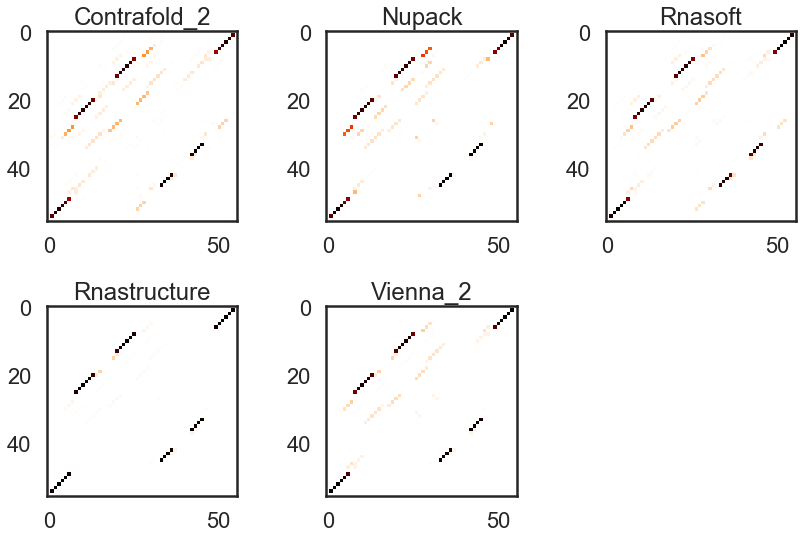

In [78]:
figure(figsize=(12,8))

for i,pkg in enumerate(sorted(avail_packages)):
    bp_matrix = bpps(sequence, package=pkg)
    subplot(2,3,i+1)
    axis(linewidth=0.5)
    imshow(bp_matrix,cmap='gist_heat_r')
    title(pkg.title())
    
tight_layout()
savefig('../assets/example_base_pair_matrices.png',dpi=150, bbox_inches='tight')

## Use base pair matrix to get p(unpaired)

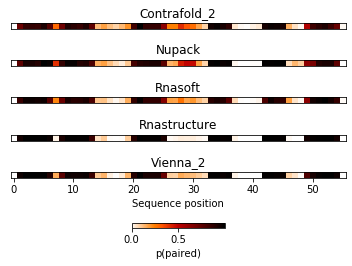

In [66]:
for i,pkg in enumerate(sorted(avail_packages)):
    bp_matrix = bpps(sequence, package=pkg)
    
    # We sum all values over one axis to get total base pairing probability per nucleotide.
    
    p_net_base_pairing = np.sum(bp_matrix, axis=0)
    
    # to get total probability unpaired, we would take 1 - p_net_base_pairing.
    subplot(6,1,i+1)
    
    imshow(p_net_base_pairing.reshape(1,-1),cmap='gist_heat_r')
    yticks([])
    title(pkg.title())
    if i==4: 
        xlabel('Sequence position')
    else:
        xticks([])
subplot(6,1,6)
axis('off')
colorbar(orientation='horizontal', label='p(paired)')
savefig('../assets/example_avg_bp_per_nucleotide.png',dpi=150, bbox_inches='tight')


## Predict MEA structure from base pair probabilities

In [62]:
from arnie.mea.mea import MEA

ground_truth_struct = '.((((((.((((((......)))))).......((((.....))))...)))))).'

for pkg in avail_packages:
    
    bp_matrix = bpps(sequence, package=pkg)
    print('Scanning gamma for %s bp probabilities' % pkg)
    print("log_g\tstruct\tE[MCC]\tMCC")
    
    for log_gamma in range(-4,4):
        mea_mdl = MEA(bp_matrix,gamma=10**log_gamma)
        [exp_sen, exp_ppv, exp_mcc, exp_fscore] = mea_mdl.score_expected()
        [sen, ppv, mcc, fscore] = mea_mdl.score_ground_truth(ground_truth_struct)

        print("%d %s %.2f %.2f" % (log_gamma, mea_mdl.structure, exp_mcc, mcc))

Scanning gamma for rnastructure bp probabilities
log_g	struct	E[MCC]	MCC
-4 ........................................................ 0.00 0.00
-3 ........................................................ 0.00 0.00
-2 ..(((..............................................))).. 0.43 0.43
-1 .((((((.(((((........))))).......((((.....))))...)))))). 0.95 0.97
0 .((((((.((((((......)))))).......((((.....))))...)))))). 0.97 1.00
1 .((((((.((((((......)))))).......((((.....))))...)))))). 0.97 1.00
2 .(((((((((((((.(...)))))))..)....((((.....))))...)))))). 0.92 1.00
3 .(((((((((((((.(...)))))))..).(..((((.....)))))..)))))). 0.90 1.00
Scanning gamma for rnasoft bp probabilities
log_g	struct	E[MCC]	MCC
-4 ........................................................ 0.00 0.00
-3 ........................................................ 0.00 0.00
-2 ........................................................ 0.00 0.00
-1 ..((................................................)).. 0.33 0.35
0 .((((((.((((((......)